### This notebook generate the line benefits from the operational cost

In [1]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [2]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150',
                                                                         150: 'st151', 151: 'st152', 152: 'st153', 153: 'st154', 154: 'st155',
                                                                         155: 'st156', 156: 'st157', 157: 'st158', 158: 'st159', 159: 'st160'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [3]:
#%% Setting up the path a cases
DirName  = os.getcwd()

CaseName_Base     = '9n'
CaseName_ByStages = CaseName_Base+'_ByStages'

CSV_name =  'oT_Data_Profiles_' + CaseName_Base

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [4]:
df_1 = pd.read_csv(_path_0+'/2.Par'+'/'+CSV_name+'.csv', index_col=0)
diff_df_1 = df_1

In [5]:
#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [6]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Solar,Wind,Hydro
2030,sc01,01-01 00:00:00+01:00,1015.040000,0.000003,270.0,0
2030,sc01,01-01 01:00:00+01:00,977.273647,0.000003,286.8,0
2030,sc01,01-01 02:00:00+01:00,910.389851,0.000003,276.8,0
2030,sc01,01-01 03:00:00+01:00,850.736052,0.000003,268.8,0
2030,sc01,01-01 04:00:00+01:00,807.390369,0.000003,265.6,0


In [7]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [8]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Solar,Wind,Hydro
LoadLevel,,,,,,
01-01 00:00:00+01:00,sc01,01-01 00:00:00+01:00,1015.040000,0.000003,270.0,0
01-01 01:00:00+01:00,sc01,01-01 01:00:00+01:00,977.273647,0.000003,286.8,0
01-01 02:00:00+01:00,sc01,01-01 02:00:00+01:00,910.389851,0.000003,276.8,0
01-01 03:00:00+01:00,sc01,01-01 03:00:00+01:00,850.736052,0.000003,268.8,0
01-01 04:00:00+01:00,sc01,01-01 04:00:00+01:00,807.390369,0.000003,265.6,0


In [9]:
# Selecting the columns demand, wind, solar, hydro
diff_df_1 = diff_df_1[['Demand', 'Wind', 'Solar', 'Hydro']]

In [10]:
ddf_1 = diff_df_1.stack()

In [11]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [12]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [13]:
ddf_1.head()

Value
LoadLevel            Execution             
01-01 00:00:00+01:00 Demand     1015.040000
                     Wind        270.000000
                     Solar         0.000003
                     Hydro         0.000000
01-01 01:00:00+01:00 Demand      977.273647

In [14]:
ddf_1 = ddf_1.reset_index()

In [15]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [16]:
# ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [17]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [18]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
34939,12-30 22:00:00+01:00,Hydro,0.000000,1900-12-30 22:00:00
34940,12-30 23:00:00+01:00,Demand,1076.413035,1900-12-30 23:00:00
34941,12-30 23:00:00+01:00,Wind,238.800000,1900-12-30 23:00:00
34942,12-30 23:00:00+01:00,Solar,0.000003,1900-12-30 23:00:00
34943,12-30 23:00:00+01:00,Hydro,0.000000,1900-12-30 23:00:00


#### Getting day of year and month

In [19]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [20]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Demand,1015.040000,1900-01-01 00:00:00,0,1,1,1
1,01-01 00:00:00+01:00,Wind,270.000000,1900-01-01 00:00:00,0,1,1,1
2,01-01 00:00:00+01:00,Solar,0.000003,1900-01-01 00:00:00,0,1,1,1
3,01-01 00:00:00+01:00,Hydro,0.000000,1900-01-01 00:00:00,0,1,1,1
4,01-01 01:00:00+01:00,Demand,977.273647,1900-01-01 01:00:00,1,1,1,1


#### Generation new ID considering each line, and hour

In [21]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [22]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
34939,12-30 22:00:00+01:00,Hydro,0.000000,1900-12-30 22:00:00,22,364,52,12,Hydro_22
34940,12-30 23:00:00+01:00,Demand,1076.413035,1900-12-30 23:00:00,23,364,52,12,Demand_23
34941,12-30 23:00:00+01:00,Wind,238.800000,1900-12-30 23:00:00,23,364,52,12,Wind_23
34942,12-30 23:00:00+01:00,Solar,0.000003,1900-12-30 23:00:00,23,364,52,12,Solar_23
34943,12-30 23:00:00+01:00,Hydro,0.000000,1900-12-30 23:00:00,23,364,52,12,Hydro_23


In [23]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [24]:
table.tail()

Variable     Demand_0    Demand_1    Demand_10    Demand_11    Demand_12  \
Month Day                                                                  
12    360  892.285540  818.861328  1042.559026  1073.688158  1050.380036   
      361  959.325900  876.493827   976.103421  1013.459544  1001.139874   
      362  937.085633  871.684539  1248.794266  1256.237001  1236.373000   
      363  987.124399  898.182775  1239.775160  1242.907363  1222.075392   
      364  975.050552  882.914373  1222.538416  1225.372234  1199.824536   

Variable     Demand_13    Demand_14    Demand_15    Demand_16    Demand_17  \
Month Day                                                                    
12    360  1044.658410  1022.435928   971.974945   953.827478   980.389817   
      361  1012.127011  1011.723052   966.436681   935.570609   956.840300   
      362  1241.616777  1217.584782  1187.745109  1182.241284  1197.243762   
      363  1220.787929  1178.650919  1129.435775  1112.223590  1136.943007   
      364  1201.688852  1174.111859  1142.138158  1133.270428  1151.083266   

Variable   ...  Wind_21  Wind_22  Wind_23  Wind_3  Wind_4  Wind_5  Wind_6  \
Month Day  ...                                                              
12    360  ...    147.2    153.6    157.6   664.4   556.4   482.4   418.0   
      361  ...    333.2    375.2    416.8   232.8   250.4   271.6   282.0   
      362  ...    310.4    313.2    326.4   390.0   375.6   341.2   311.2   
      363  ...    178.8    188.0    209.6   367.6   367.2   353.2   341.6   
      364  ...    281.6    257.2    238.8   217.6   219.2   220.8   225.2   

Variable   Wind_7  Wind_8  Wind_9  
Month Day                          
12    360   395.2   353.6   291.2  
      361   277.2   255.6   191.2  
      362   291.6   276.4   256.4  
      363   337.6   335.2   282.0  
      364   231.6   238.8   234.8  

[5 rows x 96 columns]

In [25]:
table = table.reset_index()

In [26]:
table = table.set_index(['Day'])

In [27]:
table.tail()

Variable,Month,Demand_0,Demand_1,Demand_10,Demand_11,Demand_12,Demand_13,Demand_14,Demand_15,Demand_16,...,Wind_21,Wind_22,Wind_23,Wind_3,Wind_4,Wind_5,Wind_6,Wind_7,Wind_8,Wind_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,892.285540,818.861328,1042.559026,1073.688158,1050.380036,1044.658410,1022.435928,971.974945,953.827478,...,147.2,153.6,157.6,664.4,556.4,482.4,418.0,395.2,353.6,291.2
361,12,959.325900,876.493827,976.103421,1013.459544,1001.139874,1012.127011,1011.723052,966.436681,935.570609,...,333.2,375.2,416.8,232.8,250.4,271.6,282.0,277.2,255.6,191.2
362,12,937.085633,871.684539,1248.794266,1256.237001,1236.373000,1241.616777,1217.584782,1187.745109,1182.241284,...,310.4,313.2,326.4,390.0,375.6,341.2,311.2,291.6,276.4,256.4
363,12,987.124399,898.182775,1239.775160,1242.907363,1222.075392,1220.787929,1178.650919,1129.435775,1112.223590,...,178.8,188.0,209.6,367.6,367.2,353.2,341.6,337.6,335.2,282.0
364,12,975.050552,882.914373,1222.538416,1225.372234,1199.824536,1201.688852,1174.111859,1142.138158,1133.270428,...,281.6,257.2,238.8,217.6,219.2,220.8,225.2,231.6,238.8,234.8


#### Split data table into data X and class labels y

In [28]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [29]:
print(X)
print(y)

[[1015.04       977.273647   875.6722532 ...  255.6        242.
   174.4      ]
 [ 977.3257223  875.8517315 1291.720325  ...  377.6        452.
   487.2      ]
 [1093.188316   992.4252748 1192.552795  ...  522.8        505.2
   447.6      ]
 ...
 [ 937.0856332  871.6845388 1248.794266  ...  291.6        276.4
   256.4      ]
 [ 987.1243992  898.182775  1239.77516   ...  337.6        335.2
   282.       ]
 [ 975.0505517  882.9143734 1222.538416  ...  231.6        238.8
   234.8      ]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6

## PCA step by step

#### Standardizing of the data

In [30]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [31]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.07400311  0.16005925  0.02487803 ...  0.          0.
   0.        ]
 [ 0.06287557  0.1704728   0.00194799 ...  0.          0.
   0.        ]
 [ 0.08254495  0.20152998 -0.00619213 ...  0.          0.
   0.        ]
 ...
 [ 0.18137778 -0.06181685 -0.07100605 ...  0.          0.
   0.        ]
 [ 0.18174096 -0.06595674 -0.08753243 ...  0.          0.
   0.        ]
 [ 0.18024732 -0.07226635 -0.10243665 ...  0.          0.
   0.        ]]

Eigenvalues 
[2.30381283e+01 1.93699674e+01 7.39619663e+00 4.08018906e+00
 2.62957434e+00 2.06623302e+00 1.19091781e+00 7.44146849e-01
 5.75645980e-01 4.34809636e-01 3.39840359e-01 2.60841811e-01
 1.93588819e-01 1.49263667e-01 1.35108000e-01 9.20492329e-02
 7.79198833e-02 5.85885217e-02 5.43581671e-02 4.57140745e-02
 3.86574642e-02 2.57069387e-02 2.33935791e-02 1.98383410e-02
 1.80754824e-02 1.38675901e-02 1.25551776e-02 1.11829116e-02
 9.51487190e-03 8.60859300e-03 7.02581302e-03 6.55295145e-03
 5.76530024e-03 4.72623012e-03 4.0944044

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [32]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [33]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
23.0381282788793
19.36996743238671
7.396196627948623
4.080189055319734
2.62957434228517
2.066233016131689
1.1909178066765107
0.7441468491242456
0.5756459801658955
0.4348096359526473
0.3398403592124917
0.2608418114787831
0.1935888189699895
0.149263667134683
0.1351080001987367
0.09204923291071988
0.07791988334686006
0.05858852167749624
0.05435816706559744
0.04571407454680796
0.03865746416470971
0.02570693868484295
0.023393579063091908
0.01983834095563121
0.018075482416390495
0.013867590130958021
0.01255517757627193
0.01118291159047089
0.009514871898097323
0.008608593003077553
0.007025813018804796
0.006552951446022201
0.005765300237333938
0.004726230124585632
0.004094404421955657
0.003300511211098566
0.003237012491678986
0.002667800421221245
0.0024603896266048525
0.002358096655792526
0.0018455634000713662
0.0017164588084530507
0.001489573594012023
0.0013555114544404137
0.0012802723910905376
0.0011745341035162404
0.0010780789745519677
0.0009442538019462528


### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [34]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [35]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

36.46799478995801 0
67.12950786320224 1
78.83724977819153 2
85.2959477856966 3
89.45840847926678 4
92.72913316466622 5
94.61428563206363 6
95.79222609182335 7
96.703439639705 8
97.39171758253951 9


Then

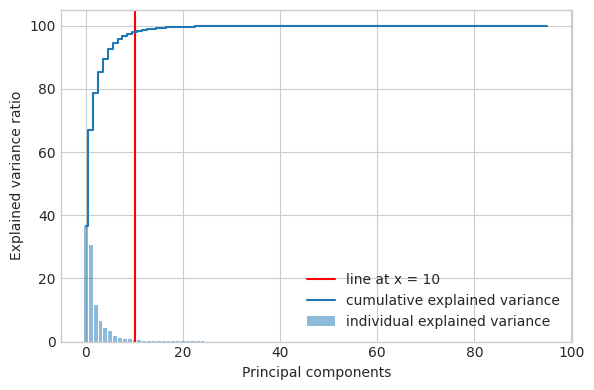

In [36]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [37]:
labels = np.unique(y, axis=0)

In [38]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

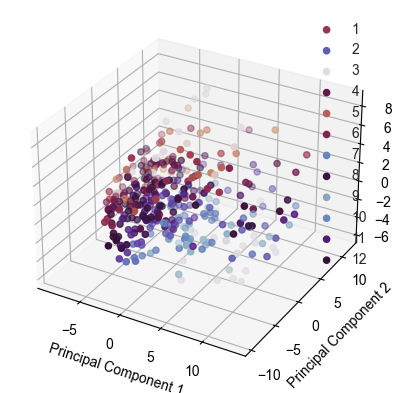

In [39]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

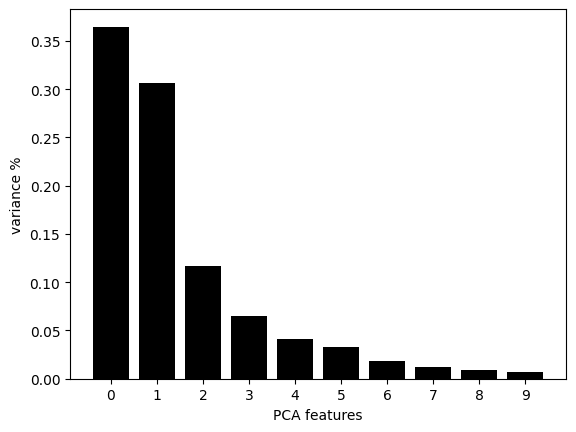

In [40]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [41]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [42]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9
0,-4.481090,4.458731,4.145745,-2.956832,-0.200321,3.455997,-0.011234,-0.081929,-0.592765,-0.182712
1,1.698354,0.900681,1.151489,-0.482789,-4.045560,0.671166,3.183873,-1.630687,0.186844,0.114360
2,1.017935,0.957945,1.592421,-2.970581,-0.033625,2.131454,0.756046,0.096357,0.068301,-0.543093
3,-1.660267,2.097176,3.190775,-2.926215,0.176341,2.644231,0.561485,-0.840082,-0.328670,0.111308
4,-3.184936,-1.354393,2.992391,-2.443952,-1.581560,0.612742,1.197827,-0.392144,-0.333028,-0.286463


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\erik_\miniconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\erik_\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for 

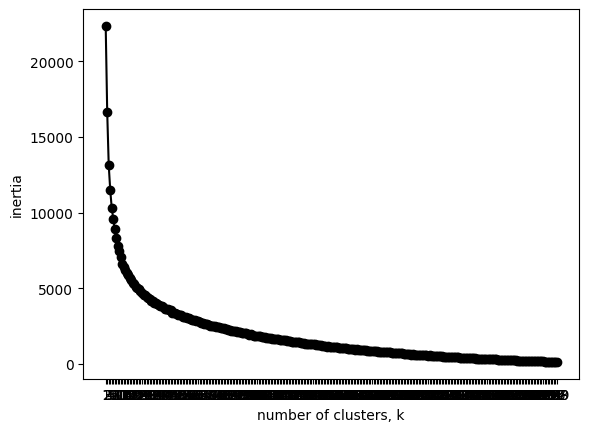

In [43]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [44]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  83


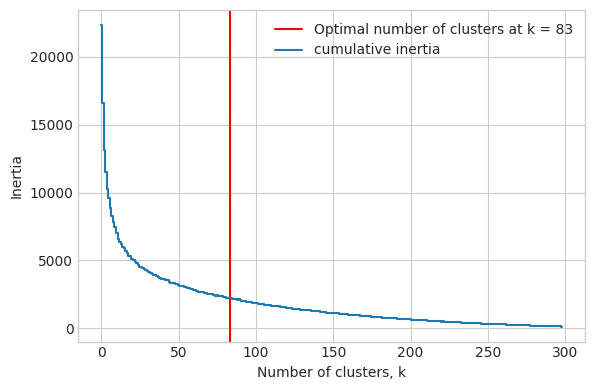

In [45]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [46]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
